# Preprocessing of strain gauges data

# Try using JULY 2021 as the baseline !!!!

In this script we preprocess the data collected by the strain gauges. 
We import data from two time periods: 
- 0. Messung to 4. Messung (7th Juli 2021 to 5th August 2021)
- 12. Messung to 18. Messung (3rd November 2021 to 12th April 2022)

The analysis of the **static behaviour** of the sheet piles is limited to the second time period, starting in November 2021. The month of November will serve as our baseline (Nullmessung). The analysis of the static behaviour is heavily based on the code by Amin Moussaid (file name Spundsteif_Analyse_essais_flexion.ipynb). 

The **effect of the temperature** on the sensors is investigated with the data from the first time period (summer 2021). 

**Input:**
*   a csv-file '`rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv`'. It contains the data automatically collected with the Catman software. This file is constructed partially by hand, partially with the help of two python scripts (they are not available on Google Colab, only on the server P:).
*   a csv-file '`rawdata_Klima_aussen.csv`'. It contains the climate data (temperature, humidity, etc.) ouside the box where all the electronics where stored. This data is used to investigate the temperature effects.
*   a csv-file '`rawdata_Piezo_nr_6.csv`'. It contains the watertables measured in piezometer nr. 6, which is the closest to the test sheet piles. It is used to gain insight into unexpected values and anomalies in the collected data.
*   a csv-file '`df_hand.csv`'. It contains data from the strain gauges that was collected by hand. This file was constructed by hand. 

**Output:**
*   a csv-file '`df_preprocessed_data_strain_gauges.csv`'. It contains the preprocessed data from the strain gauges. The data collected with the Catman Software has been downsampled on a weekly basis. Furthermore, the data collected by hand was first interpolated to match the timestamp of the automatic data collection and second merged with those data.

In [ ]:
#hide
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

# install dependency (nbdev version 1 and patch tornado problem)
!pip3 install --upgrade notebook
!pip3 install -e . -q
!pip3 install nbdev==1.2.11 -q

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# default_exp catman

# Import the libraries

In [ ]:
#export
import pandas as pd
import numpy as np
import io
import csv
from datetime import datetime, date, timedelta

from google.colab import files

from copy import copy

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import linear_model

import re

# 1.0 Import the data

# 1.1. Read the Catman data

In [ ]:
CATMAN_FILE_NAME = './data/rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv'
df_catman = pd.read_csv(CATMAN_FILE_NAME, delimiter=';')
#print(df_catman)
#print(df_catman.columns)

# important note: one column has mistakenly been labelled 'EV31'. In reality it measured the strain gauge EH31

cols = ['EH31', 'EV31']
df_catman = df_catman.assign(E = df_catman[cols].sum(1)).drop(cols, 1)
df_catman.rename(columns = {'E':'EH31'}, inplace = True)
print(df_catman)
print(df_catman.columns)

# covert the column 'Zeit' into python datetime objects and sort in chronological order

for index, row in df_catman.iterrows():
    df_catman.at[index, 'Zeit'] = datetime.strptime(df_catman.at[index, 'Zeit'], '%d.%m.%Y %H:%M')

df_catman = df_catman.sort_values('Zeit', ascending=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


      Unnamed: 0         EDSA          EDSB         EDSC  EDSD          EDSE  \
0              0  -7687.31982  2.179666e+06 -35919.26172   NaN  1.226793e+04   
1              1  -7719.16553  2.169327e+06 -35989.06641   NaN  1.233930e+04   
2              2  -7820.88623  2.159840e+06 -36016.18750   NaN  1.243958e+04   
3              3    183.08820  1.934437e+06 -20862.70313   NaN  1.955401e+04   
4              4  -8862.40723  1.705553e+06 -26351.51563   NaN  1.095719e+04   
...          ...          ...           ...          ...   ...           ...   
1885        1885 -63382.89844 -2.563729e+04          NaN   NaN -4.819262e+06   
1886        1886 -58923.52344 -2.356395e+04          NaN   NaN -4.824424e+06   
1887        1887 -44199.95703 -1.748341e+04          NaN   NaN -4.816859e+06   
1888        1888 -29251.58594 -1.084607e+04          NaN   NaN -4.816321e+06   
1889        1889 -24097.75977 -8.154800e+03          NaN   NaN -4.816772e+06   

           EDSF         EDSG     Tempa 

# 1.2. Read the climate data



In [ ]:
KLIMA_AUSSEN_FILE_NAME = './data/rawdata_Klima_aussen.csv'
df_klima = pd.read_csv(KLIMA_AUSSEN_FILE_NAME, delimiter=';')

# covert the column 'Aufnahmezeit' into python datetime objects and sort them in chronological order: 
for index, row in df_klima.iterrows():
    df_klima.at[index, 'Aufnahmezeit'] = datetime.strptime(df_klima.at[index, 'Aufnahmezeit'], '%d.%m.%Y %H:%M')

df_klima = df_klima.sort_values('Aufnahmezeit', ascending=True)
df_klima = df_klima.drop(columns='Unnamed: 0', axis=1)

print(df_klima)
print(df_klima.columns)

             Aufnahmezeit  Temperatur  Relative Luftfeuchtigkeit  Taupunkt
0     2021-07-14 11:44:00        26.3                       41.5     12.19
1     2021-07-14 12:14:00        24.8                       49.9     13.64
2     2021-07-14 12:44:00        24.0                       50.9     13.21
3     2021-07-14 13:14:00        21.3                       56.3     12.25
4     2021-07-14 13:44:00        21.0                       61.2     13.25
...                   ...         ...                        ...       ...
6410  2022-04-12 03:01:00         4.3                       80.6      1.27
6411  2022-04-12 04:01:00         3.9                       82.6      1.22
6412  2022-04-12 05:01:00         3.6                       83.8      1.12
6413  2022-04-12 06:01:00         4.8                       82.3      2.05
6414  2022-04-12 07:01:00         7.8                       75.3      3.71

[6415 rows x 4 columns]
Index(['Aufnahmezeit', 'Temperatur', 'Relative Luftfeuchtigkeit', 'Taupunkt

# 1.4. Read the data collected by hand (Handaufzeichnung)

In [ ]:
HAND_FILE_NAME = './data/df_hand.csv'
df_hand = pd.read_csv(HAND_FILE_NAME, delimiter=';')

# these columns do not contain any viable data
# We probably won't be able to analyse the data from EH13 either, but we keep it for now. 
useless_cols = ['EH12', 'EH23', 'EV21', 'VH23', 'W11', 'W21', 'W31', 'Unnamed: 22']
df_hand = df_hand.drop(columns=useless_cols, axis=1)

# covert the column 'date' into python datetime objects and sort them in chronological order: 
for index, row in df_hand.iterrows():
    df_hand.at[index, 'date'] = df_hand.at[index, 'date'] + ' 10:00' # the hand measurements always took place at about 10 am
    df_hand.at[index, 'date'] = datetime.strptime(df_hand.at[index, 'date'], '%d.%m.%Y %H:%M')

df_hand = df_hand.sort_values('date', ascending=True)

print(df_hand)
print(df_hand.columns)

                   date    EH13  EH22  EH32  EH33    EV11    EV31  VH12  VH13  \
0   2021-07-07 10:00:00 -3763.0 -6983 -5554 -5927 -4827.0 -6132.0 -4319 -3205   
1   2021-07-14 10:00:00 -3540.0 -6531 -5116 -5224 -4501.0 -5668.0 -4040 -2720   
2   2021-07-21 10:00:00     NaN -6620 -5090 -5513 -4670.0 -5671.0 -4198 -2872   
3   2021-07-28 10:00:00     NaN -6407 -4910 -5415 -4631.0 -5546.0 -4140 -2925   
4   2021-08-05 10:00:00     NaN -6422 -4897 -5412 -4662.0 -5543.0 -4126 -2924   
5   2021-08-09 10:00:00     NaN -6423 -4876 -5391 -5111.0 -5586.0 -4538 -3328   
6   2021-08-11 10:00:00     NaN -6485 -4922 -5430 -4804.0 -5584.0 -4316 -3003   
7   2021-08-18 10:00:00     NaN -6408 -4904 -5420 -4828.0     NaN -4390 -2989   
8   2021-08-25 10:00:00     NaN -6343 -4867 -5581     NaN -5550.0 -4402 -3083   
9   2021-09-22 10:00:00     NaN -6332 -4804 -5322 -5115.0 -5118.0 -4467 -3288   
10  2021-10-01 10:00:00     NaN -6177 -4658 -5218     NaN -5418.0 -4380 -3251   
11  2021-10-26 10:00:00     

# 2.0. Earth pressure sensors

In [ ]:
EDS = ['EDSA', 'EDSB', 'EDSC', 'EDSD', 'EDSE', 'EDSF', 'EDSG']
df_catman = df_catman.drop(EDS, axis=1)

# 3.0. Temperature effects

# 3.1. Sensors Temp_a and Temp_b
A correlation between temperature and strain gauges, if it exists, should be most clearly recognisable between sensors that are placed close to each other:
*   The sensor Temp_a is very close to the strain gauges EH21, EV22, and EV23
*   The sensor Temp_b is very close to the strain gauges EH11, and EV12


In [ ]:
Temperature = ['Tempa', 'Tempb']
df_catman[Temperature].describe()

,Tempa,Tempb
count,1871.000000,1890.000000
mean,11.201513,8.710881
std,1.815539,4.275832
min,8.886140,0.686990
25%,9.913610,5.677590
50%,10.153790,8.062050
75%,12.998710,10.262902
max,17.888500,44.502910


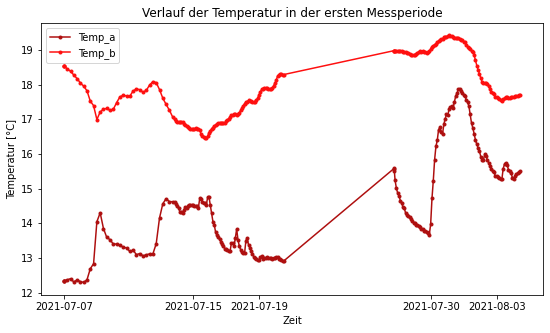

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Verlauf der Temperatur in der ersten Messperiode')

time_horizon = 219
# 219   # The first measurement period is stored in rows 0 to 218 of the dataframe

plt.plot(df_catman.Zeit[0:time_horizon], df_catman.Tempa[0:time_horizon], color='#ae0f0f', marker='.')
plt.plot(df_catman.Zeit[0:time_horizon], df_catman.Tempb[0:time_horizon], color='#fe0f0f', marker='.')

plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.xticks(df_catman.Zeit[:time_horizon:50])
plt.legend(['Temp_a', 'Temp_b'])
plt.show()

# A diurnal cycle in the temperature development is not recognisable
# Tempb is higher than Tempa. This makes sense, as the sensor Tempb is closer to the surface (summer). Tempa is deeper in the ground.

## Strain gauge EV12

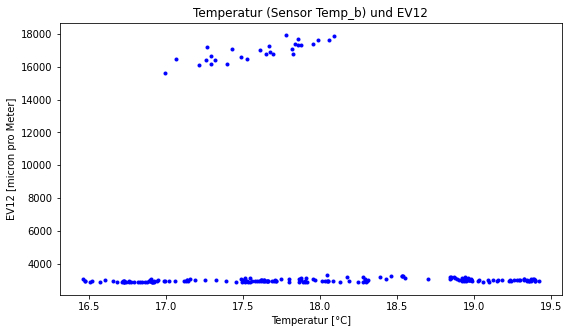

In [ ]:
# Is there a correlation between temperature and the values measured by strain gauges? 
# The sensor Tempb was placed close to EV12 and EH11. Let's investigate the effect of temperature on these two sensors. 

plt.figure(figsize=(9,5))
plt.title('Temperatur (Sensor Temp_b) und EV12')

time_horizon = 219
# 219   # The first measurement period is stored in rows 0 to 218 of the dataframe

plt.plot(df_catman.Tempb[0:time_horizon], df_catman.EV12[0:time_horizon], 'b.')
plt.xlabel('Temperatur [°C]')
plt.ylabel('EV12 [micron pro Meter]')
plt.show()

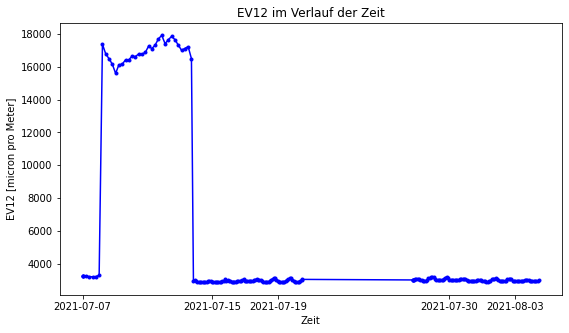

In [ ]:
plt.figure(figsize=(9,5))
plt.title('EV12 im Verlauf der Zeit')

time_horizon = 219
# 219   # The first measurement period is stored in rows 0 to 218 of the dataframe

plt.plot(df_catman.Zeit[0:time_horizon], df_catman.EV12[0:time_horizon], 'b.-')
plt.xticks(df_catman.Zeit[:time_horizon:50])
plt.xlabel('Zeit')
plt.ylabel('EV12 [micron pro Meter]')
plt.show()

In [ ]:
# The data seem anomalous over a perios of a couple of days in July (values above 14'000 micron per metre). 
# When does the anomaly occur?
df_catman.loc[df_catman['EV12'] > 14000].Zeit

8     2021-07-08 19:25:00
9     2021-07-09 00:25:00
10    2021-07-09 05:25:00
11    2021-07-09 10:25:00
12    2021-07-09 15:25:00
13    2021-07-09 20:25:00
14    2021-07-10 01:25:00
15    2021-07-10 06:25:00
16    2021-07-10 11:25:00
17    2021-07-10 16:25:00
18    2021-07-10 21:25:00
19    2021-07-11 02:26:00
20    2021-07-11 07:26:00
21    2021-07-11 12:26:00
22    2021-07-11 17:26:00
23    2021-07-11 22:26:00
24    2021-07-12 03:26:00
25    2021-07-12 08:26:00
26    2021-07-12 13:26:00
27    2021-07-12 18:26:00
28    2021-07-12 23:26:00
29    2021-07-13 04:26:00
30    2021-07-13 09:26:00
31    2021-07-13 14:26:00
32    2021-07-13 19:27:00
33    2021-07-14 00:27:00
34    2021-07-14 05:27:00
35    2021-07-14 10:27:00
Name: Zeit, dtype: object

intercept: 2344.351192869666
slope: [35.36370276]
R-squared: 0.1959284823565508


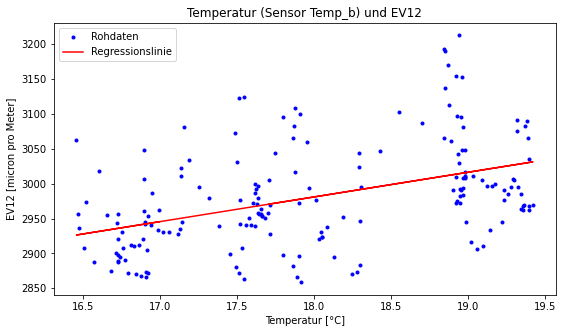

In [ ]:
# Temperature effects 14.07.2021 - 05.08.2021

# the anomaly in the data is recorded at indexes 8 - 35
# The first measurement period is stored in rows 0 to 218 of the dataframe


# fit a linear regression model to the data

my_x = pd.DataFrame(df_catman.Tempb[36:219])
my_y = df_catman.EV12[36:219]
regression_model = linear_model.LinearRegression()
regression_model.fit(X = my_x, y = my_y)

print('intercept: ' + str(regression_model.intercept_))
print('slope: ' + str(regression_model.coef_))
print('R-squared: ' + str(regression_model.score(X = my_x, y = my_y)))  # R^2 = 0.196

train_prediction = regression_model.predict(X = my_x)


# plot the result

plt.figure(figsize=(9,5))
plt.title('Temperatur (Sensor Temp_b) und EV12')

plt.plot(my_x, my_y, 'b.', label='Rohdaten')
plt.plot(my_x, train_prediction, color='red', label='Regressionslinie')
plt.xlabel('Temperatur [°C]')
plt.ylabel('EV12 [micron pro Meter]')
plt.legend()
plt.show()



# 3.2. Outside temperature

In [ ]:
# compute temperature values for the same timestamps in df_catman, based on the data in df_klima


for index, row in df_catman.iterrows():
  df_catman.at[index, 'Zeit_timestamp'] = df_catman.at[index, 'Zeit'].timestamp()

for index, row in df_klima.iterrows():
  df_klima.at[index, 'Aufnahmezeit_timestamp'] = df_klima.at[index, 'Aufnahmezeit'].timestamp()


def interpolate(my_timestamp, df, xcol, ycol):
  return np.interp([my_timestamp], df[xcol], df[ycol])


for index, row in df_catman.iterrows():
  df_catman.at[index, 'Temperatur aussen'] = interpolate(df_catman.at[index, 'Zeit_timestamp'], df_klima, 'Aufnahmezeit_timestamp', 'Temperatur')



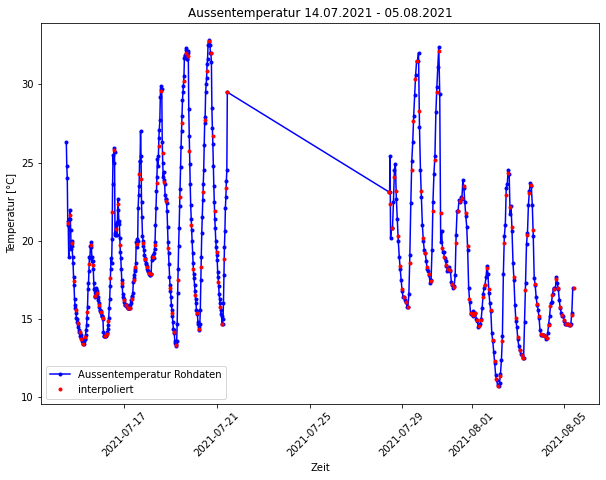

In [ ]:
# temperature effects 14.07.2021 - 05.08.2021

# df_klima: indexes 0 - 526 (included)
# df_catman: indexes 36 - 218 (included)

plt.figure(figsize=(10,7))
plt.title('Aussentemperatur 14.07.2021 - 05.08.2021')

plt.plot(df_klima.Aufnahmezeit[0:527], df_klima.Temperatur[0:527], 'b.-', label = 'Aussentemperatur Rohdaten')
plt.plot(df_catman.Zeit[36:219], df_catman['Temperatur aussen'][36:219], 'r.', label = 'interpoliert')
plt.tick_params(axis='x', rotation=45)
plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

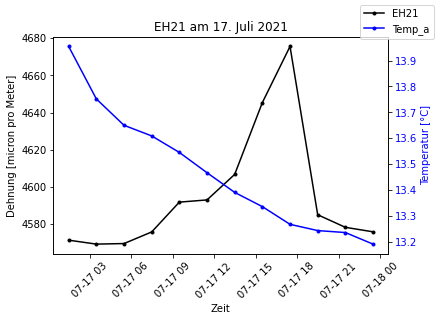

In [ ]:
# effect of temperature
# As an example, let's look at EH21 on the 17.07.2021

fig, ax1 = plt.subplots() 

ax1.set_title('EH21 am 17. Juli 2021')

ax1.plot(df_catman.Zeit[66:78], df_catman.EH21[66:78], 'k.-', label='EH21')
ax1.set_xlabel('Zeit') 
ax1.set_ylabel('Dehnung [micron pro Meter]', color = 'k') 
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'k') 


# Adding twin axes
ax2 = ax1.twinx() 

ax2.plot(df_catman.Zeit[66:78], df_catman.Tempa[66:78],'b.-', label='Temp_a')
ax2.set_ylabel('Temperatur [°C]', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
fig.legend()

fig.show()

# The data from the strain gauge does look very much like it feels the daily change in temperature 
# but the temperature sensor Temp_a is not picking up on the temperature change... Very strange!

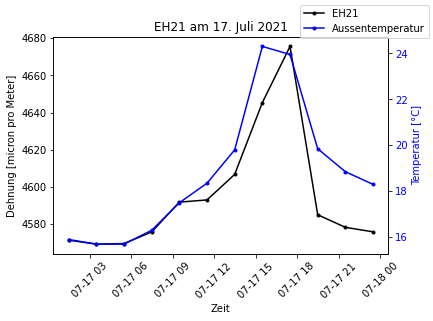

In [ ]:
# effect of temperature
# As an example, let's look at EH21 on the 17.07.2021

fig, ax1 = plt.subplots()

ax1.set_title('EH21 am 17. Juli 2021')

ax1.plot(df_catman.Zeit[66:78], df_catman.EH21[66:78], 'k.-', label='EH21')
ax1.set_xlabel('Zeit') 
ax1.set_ylabel('Dehnung [micron pro Meter]', color = 'k') 
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'k') 


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_catman.Zeit[66:78], df_catman['Temperatur aussen'][66:78], 'b.-', label='Aussentemperatur')
ax2.set_ylabel('Temperatur [°C]', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue')

fig.legend()
fig.show()

Following strain gauges are not plottable as they contain only NaN values:

*   VH11, VH21

In [ ]:
# VH11 contains only NaN
print(np.unique(df_catman.VH11[36:219]))

# VH21 contains only NaN
print(np.unique(df_catman.VH21[36:219]))

# df_catman.W11[36:219] # contains some NaN
# ... same procedure as below ...

# df_catman.W21[36:219]  # contains some NaN
# my_y = df_catman.W21[36:219]
# my_y.dropna(inplace=True)
# print(my_y)
# my_x = pd.DataFrame(df_catman['Temperatur aussen'][119:219])

[nan]
[nan]


## Electricity supply interruptions

The electricity supply was interrupted multiple times. The measurement periods correspond to following indexes in df_catman:

*   index <= 35 Anomaly in the data
*   36:119 (included) 14.07. - 21.07.2021
*   120:218 (included) 28.07. - 05.08.2021
*   219:499 (included) 03.11. - 26.11.2021
*   500:729 (included) 01.12. - 20.12.2021
*   730:866 (included) 03.02. - 09.02.2022 at 02:27 am
*   867:1048 (included) 09.02.2022 at 09:17 am - 16.02.2022
*   1049:1889 (included) 08.03. - 12.04.2022

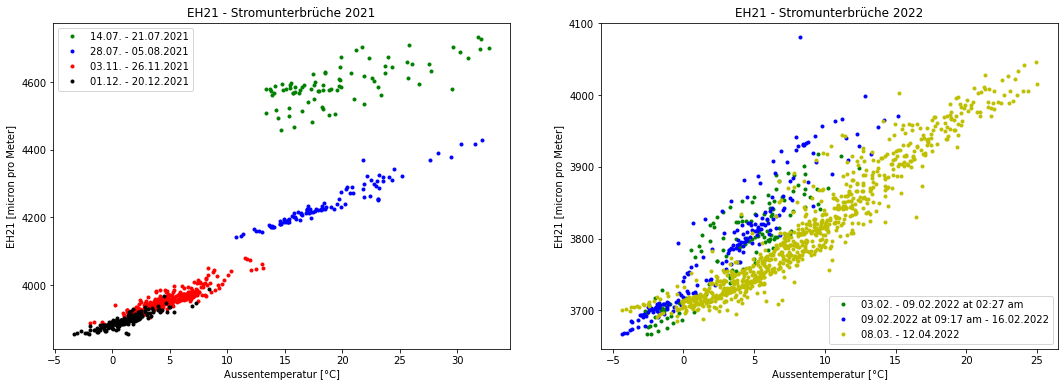

In [ ]:
# As an example, let's take a look at EH21 to understand how the electricity supply interruptions affected the data


plt.figure(figsize=(18,6))


plt.subplot(1,2,1)
plt.title('EH21 - Stromunterbrüche 2021')
plt.plot(df_catman['Temperatur aussen'][36:120], df_catman.EH21[36:120], 'g.', label='14.07. - 21.07.2021')
plt.plot(df_catman['Temperatur aussen'][120:219], df_catman.EH21[120:219], 'b.', label='28.07. - 05.08.2021')
plt.plot(df_catman['Temperatur aussen'][219:500], df_catman.EH21[219:500], 'r.', label='03.11. - 26.11.2021')
plt.plot(df_catman['Temperatur aussen'][500:730], df_catman.EH21[500:730], 'k.', label='01.12. - 20.12.2021')
plt.xlabel('Aussentemperatur [°C]')
plt.ylabel('EH21 [micron pro Meter]')
plt.legend()

plt.subplot(1,2,2)
plt.title('EH21 - Stromunterbrüche 2022')
plt.plot(df_catman['Temperatur aussen'][730:867], df_catman.EH21[730:867], 'g.', label='03.02. - 09.02.2022 at 02:27 am')
plt.plot(df_catman['Temperatur aussen'][867:1049], df_catman.EH21[867:1049], 'b.', label='09.02.2022 at 09:17 am - 16.02.2022')
plt.plot(df_catman['Temperatur aussen'][1049:1890], df_catman.EH21[1049:1890], 'y.', label='08.03. - 12.04.2022')
plt.xlabel('Aussentemperatur [°C]')
plt.ylabel('EH21 [micron pro Meter]')
plt.legend()
plt.show()

# Each monitoring period builds a cloud of points. If we were to perform a linear regression for each monitoring period, 
# we would obtain roughly the same slope, but the intercept is different.
# If we assess the effect of temperature based on data from summer 2021, will it be representative for the period 
# we actually want to analyse?

In [ ]:
# in the multi-index dataframe df_temperature we save the linear regression for each monitoring period and each strain gauge

strain_gauges = ['EH11', 'EV12', 'EH21', 'EV22', 'EV23', 'EV32', 'EV33', 'W12', 'W22', 'VH31', 'W32', 'W11', 'W21', 'EH31']
measurement_periods = ['14-07-2021', '03-11-2021', '01-12-2021', '03-02-2022', '09-02-2022', '08-03-2022']
linear_regression_output = ['intercept', 'slope', 'R_squared']

my_index = pd.MultiIndex.from_product([strain_gauges, linear_regression_output], names=['strain_gauges', 'linear_regression_output'])
df_temperature = pd.DataFrame(np.zeros([42, 6]), index=my_index, columns=measurement_periods)

df_temperature = df_temperature.T
# df_temperature

# in the dataframe df_avg_temperature we save the average temperature for each monitoring period
df_avg_temperature = pd.DataFrame(np.zeros([6, 1]), index=measurement_periods, columns=['average_temperature'])
# df_avg_temperature

intercept: 4428.248942413264
slope: [8.38137691]
R-squared: 0.5030271522859681


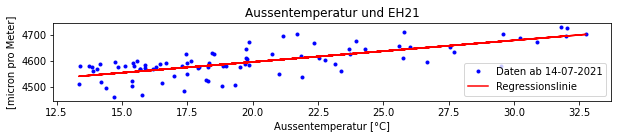

intercept: 3898.424544489062
slope: [12.05566368]
R-squared: 0.8161765897612865


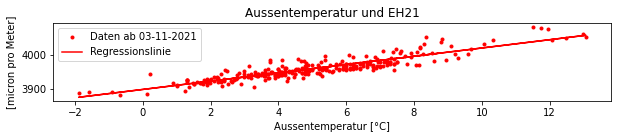

intercept: 3883.6930370011655
slope: [10.63557775]
R-squared: 0.7972100738047089


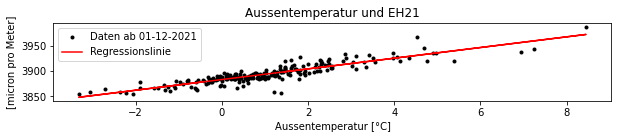

intercept: 3728.4300064842696
slope: [15.93965879]
R-squared: 0.791554001074871


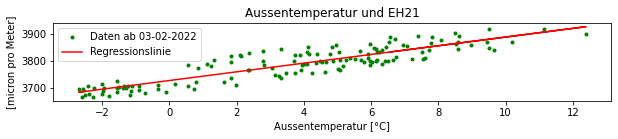

intercept: 3735.260420753878
slope: [17.97135041]
R-squared: 0.8771458371727441


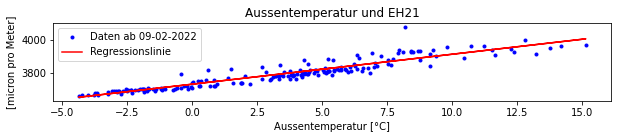

intercept: 3694.53327006847
slope: [13.58011824]
R-squared: 0.9124906648116872


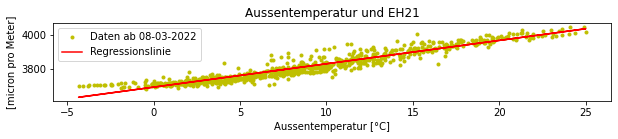

In [ ]:
df_reg = {'start_index':  [36, 219, 500, 730, 867, 1049],
          'end_index':    [120, 500, 730, 867, 1049, 1890], 
          'color':        ['b', 'r', 'k', 'g', 'b', 'y'], 
          'start_date':   ['14-07-2021', '03-11-2021', '01-12-2021', '03-02-2022', '09-02-2022', '08-03-2022']}
df_reg = pd.DataFrame(df_reg)


for i in range(6):
  my_x = pd.DataFrame(df_catman['Temperatur aussen'][df_reg.start_index[i] : df_reg.end_index[i]])
  my_y = df_catman.EH21[df_reg.start_index[i] : df_reg.end_index[i]]
  regression_model = linear_model.LinearRegression()
  regression_model.fit(X = my_x, y = my_y)

  print('intercept: ' + str(regression_model.intercept_))
  print('slope: ' + str(regression_model.coef_))
  print('R-squared: ' + str(regression_model.score(X = my_x, y = my_y)))

  # save the linear regression results in the dataframe df_temperature
  df_temperature.loc[df_reg.start_date[i], ('EH21', 'intercept')] = round(regression_model.intercept_, 1)
  df_temperature.loc[df_reg.start_date[i], ('EH21', 'slope')] = round(float(regression_model.coef_), 1)
  df_temperature.loc[df_reg.start_date[i], ('EH21', 'R_squared')] = round(regression_model.score(X = my_x, y = my_y), 2)

  train_prediction = regression_model.predict(X = my_x)

  # plot the results
  plt.figure(figsize=(10,10))
  plt.subplot(6,1,(i+1))
  plt.title('Aussentemperatur und EH21')

  plt.plot(my_x, my_y, marker='.', color=df_reg.color[i], linestyle='', label='Daten ab ' + df_reg.start_date[i])
  plt.plot(my_x, train_prediction, color='red', label='Regressionslinie')
  plt.xlabel('Aussentemperatur [°C]')
  plt.ylabel('[micron pro Meter]')
  plt.legend()
  plt.show()


In [ ]:
# inspect the multi-index dataframe df_temperature to check if it works properly
#df_temperature.loc[:,('EH21')]
#df_temperature

In [ ]:
# Now, repeat the procedure for each strain gauge. Each linear regression has been inspected 
# visually, but for the sake of conciseness have not been included in this Jupyter notebook. 
# Following obeservations can be made: 

# EV22 ---> R^2 is for some time periods (comparatively) low and for the last period it shows a two point clouds pattern (strange!)
# EV23 ---> data is complete rubbish
# W12 ---> data looks like rubbish
# VH31 ---> data looks like rubbish
# W32 ---> data looks like rubbish
# W21 ---> R-squared comparatively a bit low
# the remaining strain gauges delivered good-quality data


# construct a big for-loop to automate the process of caclulating the linear regressions

for strain_gauge in strain_gauges: # loop over each strain gauge sensor

  for i in range(6): # loop over each time period

    if (strain_gauge == 'W11' and i==0) or (strain_gauge == 'W21' and i==0):
      df_temperature.loc[df_reg.start_date[i], (strain_gauge, 'intercept')] = np.nan
      df_temperature.loc[df_reg.start_date[i], (strain_gauge, 'slope')] = np.nan
      df_temperature.loc[df_reg.start_date[i], (strain_gauge, 'R_squared')] = np.nan
    else:
      my_x = pd.DataFrame(df_catman['Temperatur aussen'][df_reg.start_index[i] : df_reg.end_index[i]])
      my_y = df_catman[strain_gauge][df_reg.start_index[i] : df_reg.end_index[i]]
      regression_model = linear_model.LinearRegression()
      regression_model.fit(X = my_x, y = my_y)

      df_temperature.loc[df_reg.start_date[i], (strain_gauge, 'intercept')] = round(regression_model.intercept_, 1)
      df_temperature.loc[df_reg.start_date[i], (strain_gauge, 'slope')] = round(float(regression_model.coef_), 1)
      df_temperature.loc[df_reg.start_date[i], (strain_gauge, 'R_squared')] = round(regression_model.score(X = my_x, y = my_y), 2)

df_temperature

strain_gauges                 EH11                      EV12                  \
linear_regression_output intercept slope R_squared intercept slope R_squared   
14-07-2021                  3610.0  13.8      0.94    2692.4  12.8      0.92   
03-11-2021                  3840.5  11.8      0.78    3534.6  12.6      0.79   
01-12-2021                  3850.3  10.1      0.78    3545.6   9.7      0.73   
03-02-2022                  3849.4  13.3      0.49    3504.1  16.7      0.71   
09-02-2022                  3886.3  18.5      0.91    3444.9  14.9      0.92   
08-03-2022                  3854.7  15.0      0.95    3466.7  15.0      0.93   

strain_gauges                 EH21                      EV22  ...       W32  \
linear_regression_output intercept slope R_squared intercept  ... R_squared   
14-07-2021                  4428.2   8.4      0.50    3379.3  ...      0.21   
03-11-2021                  3898.4  12.1      0.82    3060.7  ...      0.07   
01-12-2021                  3883.7  10.6      0.80    3048.7  ...      0.05   
03-02-2022                  3728.4  15.9      0.79    2748.8  ...      0.28   
09-02-2022                  3735.3  18.0      0.88    2724.0  ...      0.41   
08-03-2022                  3694.5  13.6      0.91    2861.5  ...      0.10   

strain_gauges                  W11                       W21                  \
linear_regression_output intercept slope R_squared intercept slope R_squared   
14-07-2021                     NaN   NaN       NaN       NaN   NaN       NaN   
03-11-2021                  3342.9  12.0      0.83    2698.2  16.7      0.45   
01-12-2021                  3346.7   9.7      0.61    2483.2  31.5      0.15   
03-02-2022                  3340.3  16.3      0.90    2331.2  19.4      0.70   
09-02-2022                  3354.6  17.5      0.92    2015.7  26.5      0.25   
08-03-2022                  3347.8  14.4      0.94    1941.2  10.8      0.34   

strain_gauges                 EH31                  
linear_regression_output intercept slope R_squared  
14-07-2021                  4504.6 -46.4      0.14  
03-11-2021                  2449.6  13.8      0.81  
01-12-2021                  2407.3  12.0      0.72  
03-02-2022                  2322.9  15.4      0.88  
09-02-2022                  2311.0  17.7      0.86  
08-03-2022                  2309.2  14.1      0.96  

[6 rows x 42 columns]

In [ ]:

# The strain gauges W11 and W21 contain only NaN for the July period. 
# we still need to use the period of november to get the baselines of these two strain gauges






In [ ]:
# caclulate the average temperature for each measurement period

for i in range(6): # loop over each time period
  df_avg_temperature.loc[df_reg.start_date[i], 'average_temperature'] = round(df_catman['Temperatur aussen'][df_reg.start_index[i] : df_reg.end_index[i]].mean(), 2)

df_avg_temperature

,average_temperature
14-07-2021,19.96
03-11-2021,4.97
01-12-2021,1.00
03-02-2022,3.68
09-02-2022,3.27
08-03-2022,8.52


In [ ]:
# Remove temperature effects 

for strain_gauge in strain_gauges: # loop over each strain gauge sensor

  # save the data in a new column named e.g. EH11_new, EV12_new, ... (instead of EH11, EV12, ...)
  strain_gauge_new = strain_gauge + str('_new') 

  for index, row in df_catman.iterrows():
    
    if (index >= 36) and (index < 120):  # Period of July

      if strain_gauge != 'W11' and strain_gauge != 'W21':
        a = df_temperature.loc['14-07-2021', (strain_gauge, 'slope')]
        T_avg = df_avg_temperature.at['14-07-2021', 'average_temperature']
        df_catman.at[index, strain_gauge_new] = df_catman.at[index, strain_gauge] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

    elif (index >= 219) and (index < 500):
      a = df_temperature.loc['03-11-2021', (strain_gauge, 'slope')]
      T_avg = df_avg_temperature.at['03-11-2021', 'average_temperature']
      df_catman.at[index, strain_gauge_new] = df_catman.at[index, strain_gauge] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

    elif (index >= 500) and (index < 730):
      a = df_temperature.loc['01-12-2021', (strain_gauge, 'slope')]
      T_avg = df_avg_temperature.at['01-12-2021', 'average_temperature']
      df_catman.at[index, strain_gauge_new] = df_catman.at[index, strain_gauge] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

    elif (index >= 730) and (index < 867):
      a = df_temperature.loc['03-02-2022', (strain_gauge, 'slope')]
      T_avg = df_avg_temperature.at['03-02-2022', 'average_temperature']
      df_catman.at[index, strain_gauge_new] = df_catman.at[index, strain_gauge] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

    elif (index >= 867) and (index < 1049):
      a = df_temperature.loc['09-02-2022', (strain_gauge, 'slope')]
      T_avg = df_avg_temperature.at['09-02-2022', 'average_temperature']
      df_catman.at[index, strain_gauge_new] = df_catman.at[index, strain_gauge] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

    elif (index >= 1049) and (index < 1890):
      a = df_temperature.loc['08-03-2022', (strain_gauge, 'slope')]
      T_avg = df_avg_temperature.at['08-03-2022', 'average_temperature']
      df_catman.at[index, strain_gauge_new] = df_catman.at[index, strain_gauge] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

    else:
      df_catman.at[index, strain_gauge_new] = np.nan


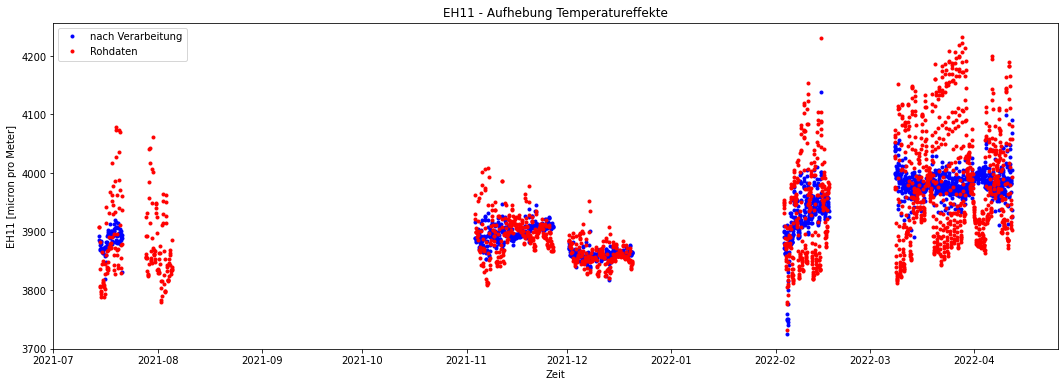

In [ ]:
# plot the result
plt.figure(figsize=(18,6))
plt.title('EH11 - Aufhebung Temperatureffekte')
plt.plot(df_catman['Zeit'][36:1890], df_catman['EH11_new'][36:1890], color='b', marker='.', linestyle='', label='nach Verarbeitung')
plt.plot(df_catman['Zeit'][36:1890], df_catman['EH11'][36:1890], color='r', marker='.', linestyle='', label='Rohdaten')
plt.xlabel('Zeit')
plt.ylabel('EH11 [micron pro Meter]')
plt.legend()
plt.show()

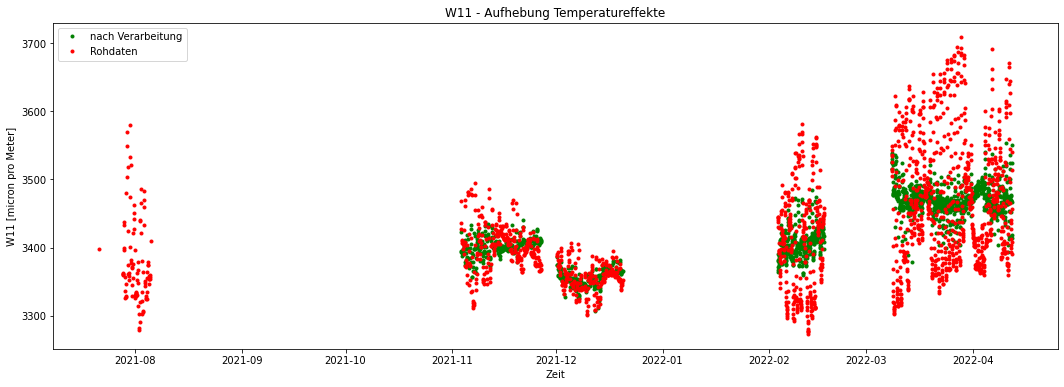

In [ ]:
# plot the result
plt.figure(figsize=(18,6))
plt.title('W11 - Aufhebung Temperatureffekte')
plt.plot(df_catman['Zeit'][36:1890], df_catman['W11_new'][36:1890], color='g', marker='.', linestyle='', label='nach Verarbeitung')
plt.plot(df_catman['Zeit'][36:1890], df_catman['W11'][36:1890], color='r', marker='.', linestyle='', label='Rohdaten')
plt.xlabel('Zeit')
plt.ylabel('W11 [micron pro Meter]')
plt.legend()
plt.show()

In [ ]:
# keep only the columns with the corrected data
#print(df_catman.tail())

for col in df_catman.columns:
  if re.search('new', col):
    dms_name = col.split('_')[0]
    df_catman = df_catman.drop(columns = dms_name, axis=1)
    df_catman.rename(columns = {col: dms_name}, inplace = True)

#print(df_catman.tail())

From now on, we will work with the data that has been corrected for temperature effects. 

# 4.0. Data pre-processing

# 4.1. Check for proper functioning of sensors
In order to establish a baseline for the static analysis, we look at the data from the 3rd of November to the 26th of November 2021. During this period of time, the underground garage in the middle of the excavation pit was realised. No excavation work took place in close proximity of the test sheet piles.

The baseline consists in the average of the values collected by each sensor from 03.11. to 26.11.2021. Even before we define the baseline, we have to check each sensor fo proper functioning. Faulty sensors are excluded from further analysis. 

In [ ]:
# The time period we want to analyse is stored in rows 219 to 499 of the dataframe df_catman

#start_baseline = datetime(2021, 11, 3)
#end_baseline = datetime(2021, 11, 27)
#start_baseline_index = df_catman.loc[df_catman['Zeit'] > start_baseline].index[0]
#end_baseline_index = max(df_catman.loc[df_catman['Zeit'] <= end_baseline].index)

#print(start_baseline_index)
#print(end_baseline_index)

In [ ]:
df_baseline = df_catman.iloc[36:120, : ]
df_baseline.describe()

,Unnamed: 0,Tempa,Tempb,VH11,VH21,Tempc,KMD1,KMD2,KMD1kompensiert,KMD2kompensiert,...,EV23,EV32,EV33,W12,W22,VH31,W32,W11,W21,EH31
count,84.000000,84.000000,84.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,0.0,0.0,84.000000
mean,77.500000,13.675033,17.226643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3260.379071,5086.897211,4872.309089,635.663663,3993.483449,5269.655195,-13658.077870,NaN,NaN,3579.283225
std,24.392622,0.660006,0.532304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,144.964698,48.868382,55.670310,1073.183150,25.513795,50.897829,3457.721842,NaN,NaN,580.775897
min,36.000000,12.910730,16.457440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2876.866610,4980.282201,4760.446250,-1255.796847,3932.394719,5088.781522,-21533.508560,NaN,NaN,2651.712863
25%,56.750000,13.033890,16.809392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3178.664025,5054.300060,4841.392778,-333.178947,3979.279428,5224.500900,-15974.141645,NaN,NaN,3009.502256
50%,77.500000,13.428035,17.040455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3316.585812,5091.202483,4871.273715,493.792062,3996.104880,5286.115860,-13293.694020,NaN,NaN,3573.076503
75%,98.250000,14.459073,17.562605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3366.369822,5116.601577,4911.865547,1582.328224,4009.150505,5307.795762,-11616.572816,NaN,NaN,4108.306520
max,119.000000,14.763450,18.301870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3473.644350,5203.393300,5038.345680,2661.867480,4045.000130,5360.677260,-6902.181890,NaN,NaN,4776.014090


In [ ]:
# standard deviation of W12, W32 and EH31 is through the roof !!!


#for strain_gauge in strain_gauges:
#  print(strain_gauge)
#  verhaeltnis = df_baseline[strain_gauge].std() / df_baseline[strain_gauge].mean()
#  verhaeltnis = round(verhaeltnis*100, 2)
#  print(f'The ratio mean to st\'dev is: {verhaeltnis} %')

## Summary - sensor malfunction

The sensor EV23 is not working properly. This is recognisable from the data, which is highly unstable. Total rubbish. Therefore, we drop this column from the dataframe.

It's far less easy to asses the sensors W12, W32, and VH31. The ratio between standard deviation and average spans between 3% and 6%, which is clearly higher than for most strain gauges (usually ca. 1%). However, in absoulte terms, it's not extremely high. Furthermore, each sensor shows a distinct pattern. For instance, the values of W32 decrease continually over the analysed timeframe. On the other hand, the values of VH31 have a clear peak around the 17th of November. Therefore, we can exclude that the variance can be traced back to one common cause (eg. groundwater table or temperature). 
The hypothesis of a malfunction of W12, W32, and VH31 has first been formulated in the chapter "Electricity supply interruptions". The fact that here we arrive ar the same conclusion indicates that this hypothesis is likely to be correct. However, at least for now, we keep these data. 

In [ ]:
# delete the data from strain gauges EV23 (nonsensical data), VH11 and VH21 (these two have only a few measurements in July)
df_catman = df_catman.drop(['EV23', 'VH11', 'VH21'], axis=1)
df_baseline = df_baseline.drop(['EV23', 'VH11', 'VH21'], axis=1) 

# 4.2. Establishing the baseline

Each strain gauge obtains its own baseline (Nullmessung), which is simply computed as the average over the baseline period, spanning from the 3rd of November to the 26th of November 2021. As it was demonstrated in chapter "Electricity supply interruptions", the strain gauges measurements can differ when resumed after an electricity cut-off. For this reason, we limit the baseline period so that it does not include any electricity supply interruption. 

In [ ]:
# baseline for data stored in df_catman
df_T0_catman = pd.DataFrame(df_baseline.mean())
df_T0_catman = df_T0_catman.transpose()
# for W11 and W21,we need to use the November's data to calculate the baseline (no data in July)
df_T0_catman['W11'] = df_catman.W11.iloc[219:500].mean()
df_T0_catman['W21'] = df_catman.W21.iloc[219:500].mean()
#print(df_T0_catman)


# baseline for data stored in df_hand

# Here I slightly extended the timeframe to include three data points: 14.07., 21.07. and 28.07.2021. 
# This has been done with the intent of obtaining a more robust baseline. 
# indexes 1 - 3 (included)
df_T0_hand = pd.DataFrame(df_hand.iloc[1:4, : ].mean())
df_T0_hand = df_T0_hand.transpose()

# the data collection for strain gauge EH13 was interrupted from the mid of July 2021 till the end of the year. 
# The baseline for this strain gauge is computed as the mean of the two measurements at the beginning of July. 
#df_T0_hand = df_T0_hand.drop(columns = 'EH13', axis=1)
#df_T0_hand['EH13'] = df_hand.EH13[0:2].mean()

#print(df_T0_hand)



# save everything in a single dataframe
df_T0 = pd.concat([df_T0_hand, df_T0_catman], axis=1)


# aesthetic fixes
df_T0 = df_T0.drop(columns = ['Unnamed: 0', 'Zeit_timestamp', 'Tempc', 'KMD1', 'KMD2', 'KMD1kompensiert', 'KMD2kompensiert'], axis = 1)
df_T0.set_axis(['Baseline July 2021'], axis=0, inplace=True)

df_T0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


,EH13,EH22,EH32,EH33,EV11,EV31,VH12,VH13,VH22,VH32,...,EV22,EV32,EV33,W12,W22,VH31,W32,W11,W21,EH31
Baseline July 2021,-3540.0,-6519.333333,-5038.666667,-5384.0,-4600.666667,-5628.333333,-4126.0,-2839.0,-4045.666667,-3117.666667,...,3590.078898,5086.897211,4872.309089,635.663663,3993.483449,5269.655195,-13658.07787,3402.597363,2781.169778,3579.283225


# 4.3. Downsampling the data

In [ ]:
# the analysis of static behaviour focuses on the period starting from the 4th of December onwards (index 533)
df_analysis = df_catman[533:]

# downsampling to a weekly frequency
df_analysis_downsample = df_analysis.resample('W', on='Zeit').mean()


# let's erase the column "Zeit_timestamp" because it has been messed up along the way of downlsampling,
# then we re-calculate the timestamp based on the index value. 
df_analysis_downsample = df_analysis_downsample.drop(columns = 'Zeit_timestamp', axis=1)

for index, row in df_analysis_downsample.iterrows():
  df_analysis_downsample.at[index, 'Zeit_timestamp'] = index.timestamp()


# aesthetic fixes
df_analysis_downsample = df_analysis_downsample.drop(columns='Unnamed: 0', axis=1)

df_analysis_downsample

# in the graphics you can see an "offset" between the rawdata (in black) and the downsampled data (in red). 
# The red points are translated to the right by a couple of days. This is related to how Python performs the
# downsampling. It calculates the average over a calendar week and then assigns the calculated mean to the 
# Sunday of that week. E.g. the data in "df_analysis" starts on the 04.12.2021, which was a Saturday. The first 
# downsampling is performed over two days, 04.12. and 05.12., and assigned to the 05.12.2021.

,Tempa,Tempb,Tempc,KMD1,KMD2,KMD1kompensiert,KMD2kompensiert,Temperatur aussen,EH11,EV12,...,EV32,EV33,W12,W22,VH31,W32,W11,W21,EH31,Zeit_timestamp
Zeit,,,,,,,,,,,,,,,,,,,,,
2021-12-05,10.708265,6.770512,NaN,NaN,NaN,NaN,NaN,2.194236,3858.700910,3554.991888,...,4366.249544,3948.019375,1872.920336,3456.715130,3693.017153,-17329.474616,3356.897029,2623.986960,2425.824807,1.638662e+09
2021-12-12,11.586697,6.220675,NaN,NaN,NaN,NaN,NaN,0.887579,3858.020103,3553.505789,...,4355.662112,3935.499564,1566.683530,3455.669198,3704.947204,-17208.037728,3347.693475,2511.225830,2417.213395,1.639267e+09
2021-12-19,11.754284,5.520574,NaN,NaN,NaN,NaN,NaN,0.659028,3862.021773,3556.796067,...,4360.820023,3943.563237,1267.375484,3458.152860,3670.407611,-16933.238896,3362.928850,2427.831760,2412.863253,1.639872e+09
2021-12-26,11.700520,5.345462,NaN,NaN,NaN,NaN,NaN,-0.794951,3863.231838,3557.801309,...,4366.773911,3949.922128,1327.710381,3454.884436,3669.470459,-16854.637629,3364.708925,2331.923528,2411.563289,1.640477e+09
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.641082e+09
2022-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.641686e+09
2022-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642291e+09
2022-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642896e+09
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.643501e+09


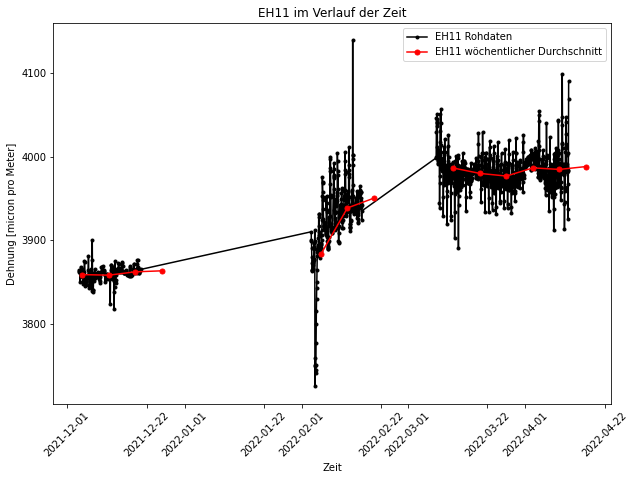

In [ ]:
# As an example, let's take a look at the downsampled data concerning the strain gauge EH11

plt.figure(figsize=(10,7))
plt.title('EH11 im Verlauf der Zeit')

plt.plot(df_analysis.Zeit, df_analysis.EH11, 'k.-', label = 'EH11 Rohdaten')
plt.plot(df_analysis_downsample.EH11, 'r.-', markersize=10, label = 'EH11 wöchentlicher Durchschnitt')
plt.tick_params(axis='x', rotation=45)
plt.xlabel('Zeit')
plt.ylabel('Dehnung [micron pro Meter]')
plt.legend()
plt.show()


# 4.4. Final processing before data analysis
In order to investigate the static behaviour of the sheet piles, we have to calculate the change measured with the strain gauges, relative to the baseline.

In [ ]:
# interpolate the data in df_hand to match the timestamps of df_analysis_downsample


for index, row in df_hand.iterrows():
  df_hand.at[index, 'date_timestamp'] = df_hand.at[index, 'date'].timestamp()


# df_hand.columns = ['date', 'EH13', 'EH22', 'EH32', 'EH33', 'EV11', 'EV31', 'VH12', 'VH13', 'VH22', 'VH32', 'VH33', 'W13', 'W23', 'W33', 'date_timestamp']
for col in df_hand.columns:
  if re.search("date", col) == None:
    for index, row in df_analysis_downsample.iterrows():
      # the function interpolate is defined in chapter "3.2. Outside temperature"
      df_analysis_downsample.at[index, col] = interpolate(df_analysis_downsample.at[index, 'Zeit_timestamp'], df_hand, 'date_timestamp', col)

df_analysis_downsample

,Tempa,Tempb,Tempc,KMD1,KMD2,KMD1kompensiert,KMD2kompensiert,Temperatur aussen,EH11,EV12,...,EV11,EV31,VH12,VH13,VH22,VH32,VH33,W13,W23,W33
Zeit,,,,,,,,,,,,,,,,,,,,,
2021-12-05,10.708265,6.770512,NaN,NaN,NaN,NaN,NaN,2.194236,3858.700910,3554.991888,...,-4909.662281,-5276.171053,-4284.530702,-3181.241228,-4833.320175,-4219.096491,-4658.833333,-4099.719298,NaN,-4164.850877
2021-12-12,11.586697,6.220675,NaN,NaN,NaN,NaN,NaN,0.887579,3858.020103,3553.505789,...,-4901.188596,-5270.644737,-4273.846491,-3199.293860,-4835.899123,-4209.517544,-4644.833333,-4089.403509,NaN,-4156.745614
2021-12-19,11.754284,5.520574,NaN,NaN,NaN,NaN,NaN,0.659028,3862.021773,3556.796067,...,-4892.714912,-5265.118421,-4263.162281,-3217.346491,-4838.478070,-4199.938596,-4630.833333,-4079.087719,NaN,-4148.640351
2021-12-26,11.700520,5.345462,NaN,NaN,NaN,NaN,NaN,-0.794951,3863.231838,3557.801309,...,-4915.318519,-5271.072222,-4266.707407,-3271.498148,-4853.888889,-4212.392593,-4635.692593,-4082.335185,-2996.400000,-4151.466667
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4945.807407,-5279.938889,-4273.862963,-3334.809259,-4872.555556,-4230.437037,-4645.337037,-4089.024074,-3013.200000,-4157.066667
2022-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4976.296296,-5288.805556,-4281.018519,-3398.120370,-4891.222222,-4248.481481,-4654.981481,-4095.712963,-3030.000000,-4162.666667
2022-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5006.785185,-5297.672222,-4288.174074,-3461.431481,-4909.888889,-4266.525926,-4664.625926,-4102.401852,-3046.800000,-4168.266667
2022-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5037.274074,-5306.538889,-4295.329630,-3524.742593,-4928.555556,-4284.570370,-4674.270370,-4109.090741,-3063.600000,-4173.866667
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5067.762963,-5315.405556,-4302.485185,-3588.053704,-4947.222222,-4302.614815,-4683.914815,-4115.779630,-3080.400000,-4179.466667


In [ ]:
# remove from the strain gauges data the baseline value

for sensor in df_T0.columns:
  if re.search("Temp", sensor) == None:
    for index, row in df_analysis_downsample.iterrows():
      df_analysis_downsample.at[index, sensor] = df_analysis_downsample.at[index, sensor] - df_T0[sensor]

# now the dataframe df_analysis_downsample contains the delta relative to the baseline


df_analysis_downsample

,Tempa,Tempb,Tempc,KMD1,KMD2,KMD1kompensiert,KMD2kompensiert,Temperatur aussen,EH11,EV12,...,EV11,EV31,VH12,VH13,VH22,VH32,VH33,W13,W23,W33
Zeit,,,,,,,,,,,,,,,,,,,,,
2021-12-05,10.708265,6.770512,NaN,NaN,NaN,NaN,NaN,2.194236,-26.986970,607.579879,...,-308.995614,352.162281,-158.530702,-342.241228,-787.653509,-1101.429825,373.833333,-135.052632,NaN,465.149123
2021-12-12,11.586697,6.220675,NaN,NaN,NaN,NaN,NaN,0.887579,-27.667777,606.093780,...,-300.521930,357.688596,-147.846491,-360.293860,-790.232456,-1091.850877,387.833333,-124.736842,NaN,473.254386
2021-12-19,11.754284,5.520574,NaN,NaN,NaN,NaN,NaN,0.659028,-23.666108,609.384057,...,-292.048246,363.214912,-137.162281,-378.346491,-792.811404,-1082.271930,401.833333,-114.421053,NaN,481.359649
2021-12-26,11.700520,5.345462,NaN,NaN,NaN,NaN,NaN,-0.794951,-22.456043,610.389300,...,-314.651852,357.261111,-140.707407,-432.498148,-808.222222,-1094.725926,396.974074,-117.668519,536.600000,478.533333
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-345.140741,348.394444,-147.862963,-495.809259,-826.888889,-1112.770370,387.329630,-124.357407,519.800000,472.933333
2022-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-375.629630,339.527778,-155.018519,-559.120370,-845.555556,-1130.814815,377.685185,-131.046296,503.000000,467.333333
2022-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-406.118519,330.661111,-162.174074,-622.431481,-864.222222,-1148.859259,368.040741,-137.735185,486.200000,461.733333
2022-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-436.607407,321.794444,-169.329630,-685.742593,-882.888889,-1166.903704,358.396296,-144.424074,469.400000,456.133333
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-467.096296,312.927778,-176.485185,-749.053704,-901.555556,-1184.948148,348.751852,-151.112963,452.600000,450.533333


# 5.0. Export the strain gauges data
In this Jupyter notebook we illustrated the preprocessing required to perform the actual analysis of strain gauges data. To summarise, following steps have been taken:

Data collected automatically with the Catman software:
*   check for proper functioning of sensors
*   compute baseline based on measurement period 3rd - 26th November 2021
*   estimation and correction of temperature effects
*   downsampling on a weekly basis

Data collected by hand:
*   compute baseline based on three data points (26.10., 03.11. and 01.12.2021)
*   linear interpolation to match the timestamps of the data collected automatically
*   due to lack of data, a correction of temperature effects was not undertaken
*   merging with the data collected automatically

We now export the preprocessed data and will proceed to analyse them in the script '`06_strain_gauges.ipynb`'. 

In [ ]:
df_analysis_downsample.to_csv('./data/df_preprocessed_data_strain_gauges_JULY_BASELINE.csv')

# 9.9. Stuff to be erased from final version

Across the Jupyter-Notebook there are some code fragments that do not belong in the final version. You can easily find them by typing "To be erased" in the search bar.